## Importing necessary libraries

In [1]:
from __future__ import print_function, division
import os
from os import walk
import sys
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm
import re

PATH = '../input/covid19-pneumonia-normal-chest-xray-pa-dataset' # Path of the dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    
all_best_accs = []

Using CUDA


## Funtion to initialize model and Fine tune the pretrained models 
#### These models have 1000 classes in output layer since they are trained on imagenet. We fine tune it to three
#### We'll be using Resnet, Alexnet, VGG16, Squeezenet, Densenet, InceptionV3 with pretrained weights. There are other models too but most of them are difficult to fine tune (some have multiple output layers,etc) 

In [2]:
available_models = ["resnet","alexnet","vgg","squeezenet","densenet","inception"]

def set_parameter_requires_grad(model, feature_extracting): #function to freezing parameters in our model
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes = 3, feature_extract = True, use_pretrained=True): # num_classes=3 
                                                                                                #since we have 3 classes
    
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    
    model_name = model_name.lower() 
    model_name.replace(" ", "") # removing spaces in string
    model_name = re.sub(r'[0-9]',"",model_name) # removing numbers in string
    
    
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_name = "Resnet18"
        model_ft = models.resnet18(pretrained=use_pretrained) # using pretrained weights
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)   # setting number of outputs to 3 (initially most models have number of 
                                                         #  outputs as 1000 since they are trained on imagenet)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_name = "Alexnet"
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_name = "VGG16 with batch normalization"
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_name = "Squeezenet"
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_name = "Densenet"
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has two outputs normal output and auxiliary output
        """
        model_name = "Inception v3"
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    model_ft = model_ft.to(device)
    return model_ft, input_size

### Checking the above function

In [3]:
# available_models = ["resnet","alexnet","vgg","squeezenet","densenet","inception"]
model_name = "inception"
model, size = initialize_model(model_name)
print("model =",model_name,"\nsize of image = "+ str(size)) # optimal size of the image to be given input

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

model = inception 
size of image = 299


## Data Augmentation and Creating the Dataset loader

In [4]:
data_dir = PATH 
batch_size = 32
valid_size = 0.1 # define partition of validation size in train size

# Defining transforms for the training data and testing data
data_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                       transforms.Resize((size,size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])


# obtain training indices that will be used for validation
data = datasets.ImageFolder(data_dir , transform= data_transforms)
dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
num_train = len(data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
data_loader = {"train" : train_loader, "val" : val_loader}
phases = ["train", "val"]
class_names = data.classes

print("The Classes are : ",end = "")
print(*class_names,sep = ", ")


The Classes are : covid, normal, pneumonia


##  Visualizing an image from the dataset loader

torch.Size([3, 299, 299])


<AxesSubplot:>

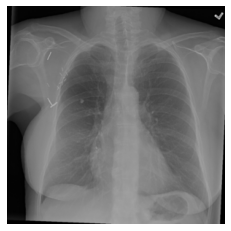

In [5]:
def imshow1(image, ax=None, title=None, normalize=True):
    #Imshow for Tensor
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0., 0., 0.])
        std = np.array([1., 1., 1.])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

data_iter = iter(val_loader)

images, labels = next(data_iter)
print(images[0].shape)
imshow1(images[0])

## Function for training the models
#### Note: Inception will give two outputs(normal output and auxlilary output) while training here but will give only one output while testing/evaluating  

In [6]:
def train_model(model, criterion, optimizer, scheduler, epochs= 3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch, (inputs, labels) in enumerate(data_loader[phase]):
                print("\r batch {}/{}".format(batch+1, len(data_loader[phase])), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        outputs,aux = model(inputs)
                    else:
                        outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        loss = criterion(outputs,labels) + 0.4*criterion(aux,labels)
                    else:
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    all_best_accs.append(best_acc)
    return model

## It'll take a lot of time for train training (about an hour on GPU) as we are training six models in a huge dataset, so grab your ☕ or 🍿 while training
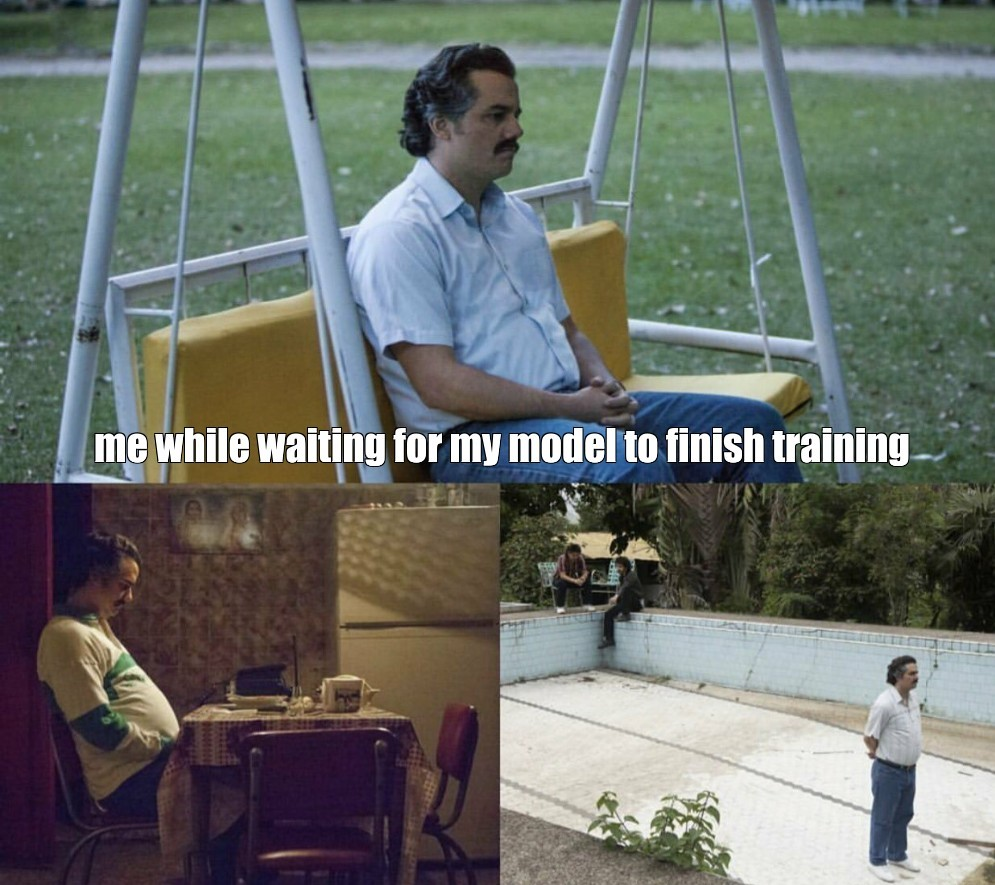

## Training all the models in a loop 
### some models have different prescribed image size, so creating data loaders for each models separately 
#### I'm also saving the best state of all the models in a .pt file for each

In [7]:
model = {x:[] for x in available_models}

begin_tol = time.time()

for model_name in available_models:
    
    # ----------------> Initialization part
    model[model_name], size = initialize_model(model_name)
    
    
    # ----------------> Data loader part
    data_dir = PATH
    batch_size = 32
    valid_size = 0.1 # define partition of validation size in train size

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                           transforms.Resize((size,size)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])


    # obtain training indices that will be used for validation
    data = datasets.ImageFolder(data_dir , transform=train_transforms)
    dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
    num_train = len(data)

    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))

    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
    data_loader = {"train" : train_loader, "val" : val_loader}
    modes = ["train", "val"]
    class_names = data.classes    
    
    # ----------------> Training part    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model[model_name].parameters(), lr = 0.01, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    
    print("\n"+"\033[1m" + model_name.upper() + "\033[0m")
    
    train_model(model[model_name], criterion, optimizer, exp_lr_scheduler, epochs = 3)
    torch.save(model[model_name].state_dict(), model_name+'_covid_xray.pt')

    
 # We get the total time for training of all the models    
tol_time = time.time()-begin_tol 
print('Total training completed in {:.0f}m {:.0f}s'.format(tol_time // 60, tol_time % 60))

# Finding the best model on the validation set
overall_best_acc = max(all_best_accs)
best_model_name = available_models[all_best_accs.index(overall_best_acc)]
print("best model is "+best_model_name.upper()+" with accuracy of "+str(overall_best_acc.item()*100)[:6]+" %")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


RESNET
Epoch 1/3
----------
 batch 195/195
train Loss: 0.5192 Acc: 0.8155
 batch 22/22
val Loss: 1.4097 Acc: 0.5435

Epoch 2/3
----------
 batch 195/195
train Loss: 0.4959 Acc: 0.8643
 batch 22/22
val Loss: 0.5912 Acc: 0.7971

Epoch 3/3
----------
 batch 195/195
train Loss: 0.4149 Acc: 0.8656
 batch 22/22
val Loss: 0.6399 Acc: 0.7783

Training complete in 9m 8s
Best val Acc: 0.797101


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]


ALEXNET
Epoch 1/3
----------
 batch 195/195
train Loss: 2.1369 Acc: 0.7446
 batch 22/22
val Loss: 1.1777 Acc: 0.8087

Epoch 2/3
----------
 batch 195/195
train Loss: 1.6804 Acc: 0.7746
 batch 22/22
val Loss: 1.1067 Acc: 0.8290

Epoch 3/3
----------
 batch 195/195
train Loss: 1.5439 Acc: 0.7831
 batch 22/22
val Loss: 1.9273 Acc: 0.7449

Training complete in 7m 46s
Best val Acc: 0.828986


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


VGG
Epoch 1/3
----------
 batch 195/195
train Loss: 0.5801 Acc: 0.8063
 batch 22/22
val Loss: 0.3019 Acc: 0.8855

Epoch 2/3
----------
 batch 195/195
train Loss: 0.5395 Acc: 0.8316
 batch 22/22
val Loss: 0.4329 Acc: 0.8797

Epoch 3/3
----------
 batch 195/195
train Loss: 0.5251 Acc: 0.8427
 batch 22/22
val Loss: 0.3699 Acc: 0.8957

Training complete in 9m 24s
Best val Acc: 0.895652


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


  0%|          | 0.00/4.79M [00:00<?, ?B/s]


SQUEEZENET
Epoch 1/3
----------
 batch 195/195
train Loss: 1.0891 Acc: 0.3569
 batch 22/22
val Loss: 1.0096 Acc: 0.3928

Epoch 2/3
----------
 batch 195/195
train Loss: 0.9922 Acc: 0.3661
 batch 22/22
val Loss: 0.9955 Acc: 0.4319

Epoch 3/3
----------
 batch 195/195
train Loss: 0.9093 Acc: 0.4933
 batch 22/22
val Loss: 0.8675 Acc: 0.5101

Training complete in 8m 4s
Best val Acc: 0.510145


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]


DENSENET
Epoch 1/3
----------
 batch 195/195
train Loss: 0.5775 Acc: 0.8194
 batch 22/22
val Loss: 0.2999 Acc: 0.9130

Epoch 2/3
----------
 batch 195/195
train Loss: 0.4284 Acc: 0.8631
 batch 22/22
val Loss: 0.3135 Acc: 0.9203

Epoch 3/3
----------
 batch 195/195
train Loss: 0.3498 Acc: 0.8860
 batch 22/22
val Loss: 0.4778 Acc: 0.8739

Training complete in 8m 37s
Best val Acc: 0.920290

INCEPTION
Epoch 1/3
----------
 batch 195/195
train Loss: 0.7242 Acc: 0.7852
 batch 22/22
val Loss: 0.3025 Acc: 0.9072

Epoch 2/3
----------
 batch 195/195
train Loss: 0.6016 Acc: 0.8329
 batch 22/22
val Loss: 0.2863 Acc: 0.8986

Epoch 3/3
----------
 batch 195/195
train Loss: 0.6213 Acc: 0.8266
 batch 22/22
val Loss: 0.3253 Acc: 0.9043

Training complete in 9m 24s
Best val Acc: 0.907246
Total training completed in 53m 11s
best model is DENSENET with accuracy of 92.028 %


## Now testing on the whole dataset
### Creating the funtion for testing all the models

In [8]:
all_best_accs_test = []
def test_model(model, criterion, optimizer, scheduler, epochs= 3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print('-' * 10)
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for batch, (inputs, labels) in enumerate(data_loader):
        print("\rbatch {}/{}".format(batch+1, len(data_loader)), end='', flush=True)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

#                 if batch == 3:
#                     break

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        phase = "test"
    print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    best_acc = epoch_acc
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    all_best_accs_test.append(best_acc)


### Testing on the whole dataset
#### We'll test each model on a loop just like we did in testing 
##### This will take about 15 mins 

In [9]:
model_c = {x:[] for x in available_models}
begin_tol = time.time()
for model_name in available_models:
    
    model_c[model_name], size = initialize_model(model_name)
    model_c[model_name].load_state_dict(torch.load("./"+model_name+"_covid_xray.pt"))
    data_dir = PATH
    batch_size = 32
    valid_size = 0.1 # define partition of validation size in train size

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                           transforms.Resize((size,size)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])


    # obtain training indices that will be used for validation
    data = datasets.ImageFolder(data_dir , transform=train_transforms)
    dataset_size = len(data)
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)

    class_names = data.classes    
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_c[model_name].parameters(), lr = 0.01, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    print("\n"+"\033[1m" + model_name.upper() + "\033[0m")
    test_model(model_c[model_name], criterion, optimizer, exp_lr_scheduler, epochs = 3)


tol_time = time.time()-begin_tol
print('Total testing completed in {:.0f}m {:.0f}s'.format(tol_time // 60, tol_time % 60))
overall_best_acc = max(all_best_accs_test)
best_model_name = available_models[all_best_accs_test.index(overall_best_acc)]

print("best model is "+best_model_name.upper()+" with accuracy of "+str(overall_best_acc.item()*100)[:6]+" %")


RESNET
----------
batch 216/216
test Loss: 0.4936 Acc: 0.8103

Training complete in 2m 40s
Best val Acc: 0.810345

ALEXNET
----------
batch 216/216
test Loss: 1.0434 Acc: 0.8253

Training complete in 2m 40s
Best val Acc: 0.825268

VGG
----------
batch 216/216
test Loss: 0.3394 Acc: 0.8999

Training complete in 3m 11s
Best val Acc: 0.899884

SQUEEZENET
----------
batch 216/216
test Loss: 0.8602 Acc: 0.5394

Training complete in 2m 43s
Best val Acc: 0.539409

DENSENET
----------
batch 216/216
test Loss: 0.2649 Acc: 0.9251

Training complete in 2m 54s
Best val Acc: 0.925094

INCEPTION
----------
batch 216/216
test Loss: 0.3111 Acc: 0.8984

Training complete in 3m 10s
Best val Acc: 0.898435
Total testing completed in 17m 25s
best model is DENSENET with accuracy of 92.509 %


## That did took a while 😅
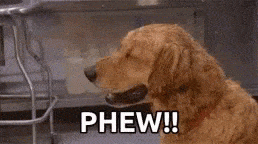
#### Ok, lets get back

#### If you want to use any model, download the .pt file from the output folder and just follow the code below:
#### model, size = initialize_model(model_name)   #dont forget to copy the initialize_model function
#### model.load_state_dict(torch.load(model_name+"_covid_xray.pt"))

#### 🥧 Voilà the model is ready to use
## Hope you find this useful 😁 👍🏻
### Any comments on changes or improvements, etc would really help. 
#### Thanks in advance 👍🏻